In [1]:
!pip install pydub
!pip install tensorflow_io
!pip install TensorBoard
!pip install -U tensorboard_plugin_profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.37.0
    Uninstalling tensorflow-io-gcs-filesystem-0.37.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.9 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Load data
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
val = ds['validation']

2024-07-10 16:02:18.921492: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-07-10 16:02:18.921508: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-07-10 16:02:18.921513: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-07-10 16:02:18.921531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 16:02:18.921541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
#visual class names
info = tfds.builder(f'speech_commands:0.0.{version}').info
class_names = info.features['label'].names
for i,c in enumerate(class_names):
    print(f'{i}: {c}')


0: down
1: go
2: left
3: no
4: off
5: on
6: right
7: stop
8: up
9: yes
10: _silence_
11: _unknown_


In [3]:
# custom MFCC function
# An integer representing the sampling rate.
sr = 16000
# An integer scalar Tensor. The window length in samples.
frame_length = int(sr/40) #25 ms
# An integer scalar Tensor. The number of samples to step.
frame_step = int(sr/100) #10 ms
# An integer scalar Tensor. The size of the FFT to apply.
fft_length = int(sr/40) #25 ms
# An integer representing the num of filterbanks.
num_feats = 40

def get_mfccs(
        audio,
        channels= 1,
        sample_rate= 16000,
        frame_length= 400,
        frame_step = 160,
        fft_length = 400,
        num_feats = 40
    ):
    audio = tf.cast(audio, tf.float32)
    audio = audio[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)
    stfts = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0 , sample_rate/2, num_feats
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)
    mfccs = mfccs[..., tf.newaxis]

    return mfccs


In [4]:
# Preprocessing function
def preprocess_data(example):
    audio = example['audio']
    label = example['label']
    # label = tf.one_hot(label, 12)
    mfccs = get_mfccs(audio)
    return mfccs, label

In [5]:
# Create dataset
train_samples = train
train_data = train_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [6]:
#batch
batch_size = 32
train_data_batched = train_data.batch(batch_size)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(inputs, filters, kernel_size=(3, 3), strides=(1, 1)):
    """A basic residual block for ResNet."""
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides != (1, 1) or inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_bc_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    # x = residual_block(x, 64)

    x = residual_block(x, 128, strides=(2, 2))
    # x = residual_block(x, 128)

    x = residual_block(x, 256, strides=(2, 2))
    # x = residual_block(x, 256)

    # x = residual_block(x, 512, strides=(2, 2))
    # x = residual_block(x, 512)

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model




In [8]:
# Example usage
input_shape = (98, 40, 1)  # Shape of the MFCC input
num_classes = 12  # Number of output classes
model = build_bc_resnet(input_shape, num_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 98, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 49, 20,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 49, 20,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 49, 20,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 10,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 10,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 10,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 25, 10,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 10,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 10,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 10,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 25, 10,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 13, 5,     │     73,856 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 5,     │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 13, 5,     │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 13, 5,     │    147,584 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 13, 5,     │      8,320 │ re_lu_2[0][0]   

 Total params: 1,299,340 (4.96 MB)

 Trainable params: 1,296,652 (4.95 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

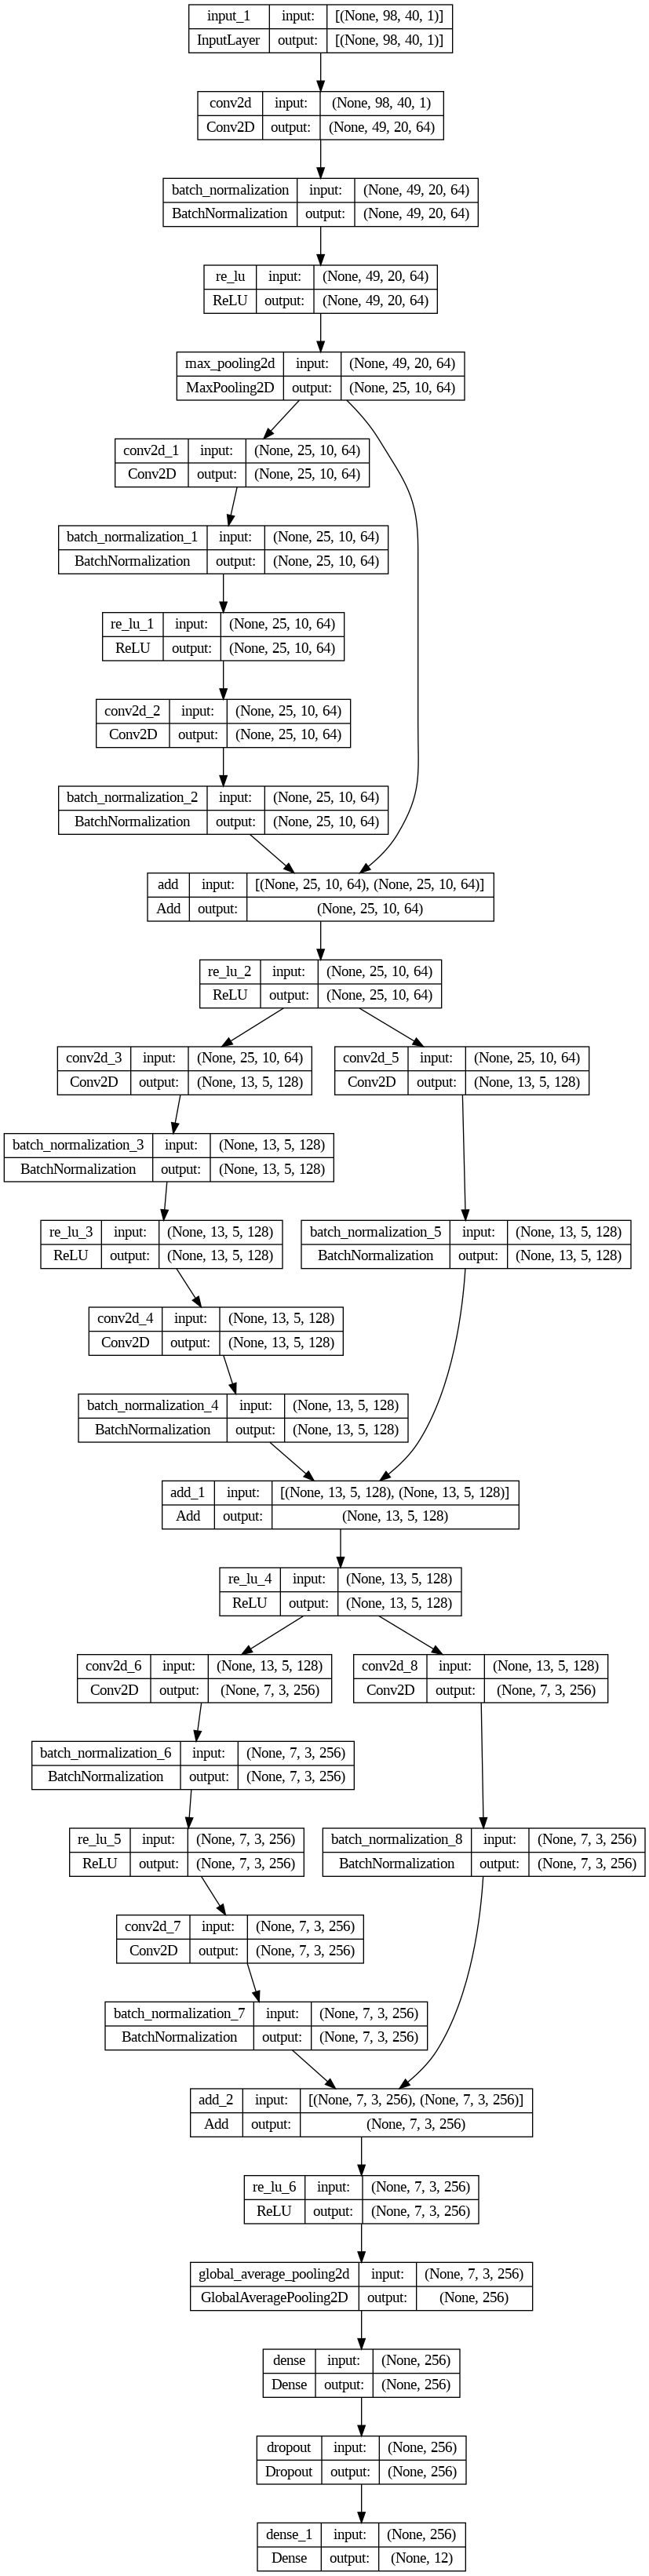

In [13]:
#plot model
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
#preprocess validation data
val_samples = val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_samples_batched = val_samples.batch(32)

In [15]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Define TensorBoard callback
log_dir = "logs/fit/"  # Define your log directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1,  profile_batch = '0')

# Define ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='res_net/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [16]:
# Train the model
history = model.fit(
    train_data_batched,
    epochs=20,
    validation_data=val_samples_batched,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/20
2673/2673 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.8106
Epoch 1: saving model to res_net/best_model_epoch_01_val_acc_0.90.weights.h5
2673/2673 [==============================] - 119s 40ms/step - loss: 0.6094 - accuracy: 0.8106 - val_loss: 0.3110 - val_accuracy: 0.9044
Epoch 2/20
2670/2673 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.9199
Epoch 2: saving model to res_net/best_model_epoch_02_val_acc_0.89.weights.h5
2673/2673 [==============================] - 103s 38ms/step - loss: 0.2563 - accuracy: 0.9199 - val_loss: 0.3398 - val_accuracy: 0.8914
Epoch 3/20
2672/2673 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9414
Epoch 3: saving model to res_net/best_model_epoch_03_val_acc_0.94.weights.h5
2673/2673 [==============================] - 105s 39ms/step - loss: 0.1886 - accuracy: 0.9414 - val_loss: 0.1936 - val_accuracy: 0.9420
Epoch 4/20
2672/2673 [============================>.] - ETA: 0s - l

In [17]:
# Save the model
model.save("audio_classifier_MFCC_res_net.keras")

In [18]:
# Load the model
model = tf.keras.models.load_model("audio_classifier_MFCC_res_net.keras")

In [19]:
# Test the model
test = ds['test']
test_samples = test
test_data = test_samples.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data_batched = test_data.batch(32)
test_loss, test_acc = model.evaluate(test_data_batched)
print('test_acc:', test_acc, 'test_loss', test_loss)


153/153 [==============================] - 7s 38ms/step - loss: 0.4733 - accuracy: 0.9249
test_acc: 0.9249488711357117 test_loss 0.4732564687728882


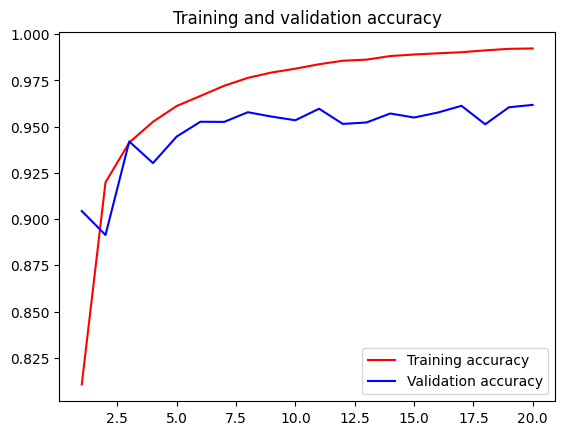

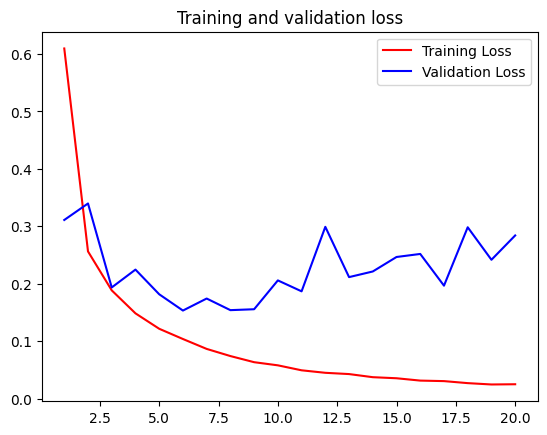

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.clf()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
# load each weights to evaluate on test set
import os

weights_dir = 'res_net'
weights_files = os.listdir(weights_dir)
weights_files = [f for f in weights_files if f.endswith('.h5')]
weights_files.sort()

test_accs = []
test_losses = []

for weights in weights_files:
    model.load_weights(os.path.join(weights_dir, weights))
    test_loss, test_acc = model.evaluate(test_data_batched)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    print(f'{weights} test_acc: {test_acc}, test_loss: {test_loss}')


153/153 [==============================] - 4s 22ms/step - loss: 0.5634 - accuracy: 0.8143
best_model_epoch_01_val_acc_0.90.weights.h5 test_acc: 0.8143149018287659, test_loss: 0.5633875727653503
153/153 [==============================] - 4s 22ms/step - loss: 0.4835 - accuracy: 0.8411
best_model_epoch_02_val_acc_0.89.weights.h5 test_acc: 0.84110426902771, test_loss: 0.48349276185035706
153/153 [==============================] - 5s 29ms/step - loss: 0.2817 - accuracy: 0.9045
best_model_epoch_03_val_acc_0.94.weights.h5 test_acc: 0.9044989943504333, test_loss: 0.2817411422729492
153/153 [==============================] - 4s 22ms/step - loss: 0.2930 - accuracy: 0.9047
best_model_epoch_04_val_acc_0.93.weights.h5 test_acc: 0.9047034978866577, test_loss: 0.2929832637310028
153/153 [==============================] - 4s 22ms/step - loss: 0.2705 - accuracy: 0.9147
best_model_epoch_05_val_acc_0.94.weights.h5 test_acc: 0.9147239327430725, test_loss: 0.27051758766174316
153/153 [=====================

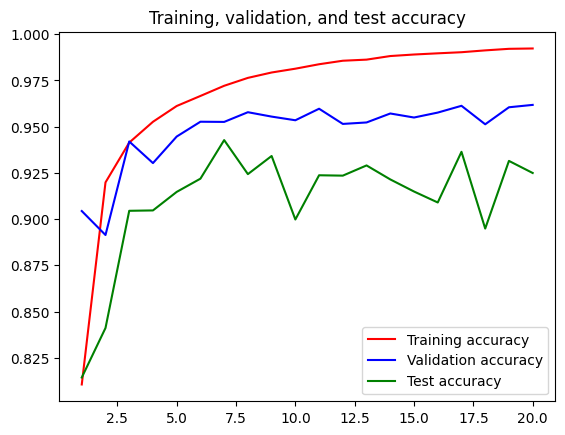

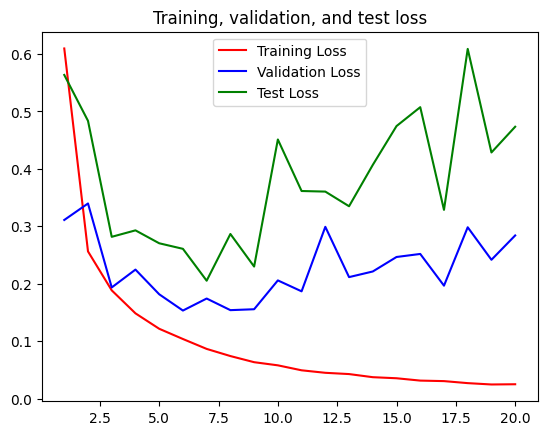

In [22]:
# Plot test accuracy and loss with train and validation accuracy and loss
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, test_accs, 'g', label='Test accuracy')
plt.title('Training, validation, and test accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.plot(epochs, test_losses, 'g', label='Test Loss')
plt.title('Training, validation, and test loss')
plt.legend()
plt.show()

In [25]:
# seems that 7 epochs gave the best result
model.load_weights(os.path.join(weights_dir, weights_files[6]))
model.evaluate(test_data_batched)

153/153 [==============================] - 4s 23ms/step - loss: 0.2054 - accuracy: 0.9427


[0.2053920030593872, 0.942740261554718]

# MAC Computation and GPU Memory Usage

## 1. MAC Computation

**Convolutional Layer ($\text{Conv2D}$)**

$$
\text{MACs} = \text{batch\_size} \times h_{\text{out}} \times w_{\text{out}} \times k_h \times k_w \times c_{\text{in}} \times c_{\text{out}}
$$

Where:
- $\text{batch\_size}$ = Number of samples in the batch
- $h_{\text{out}}$ = Height of the output feature map
- $w_{\text{out}}$ = Width of the output feature map
- $k_h$ = Height of the kernel
- $k_w$ = Width of the kernel
- $c_{\text{in}}$ = Number of input channels
- $c_{\text{out}}$ = Number of output channels (filters)

**Dense Layer ($\text{Dense}$)**

$$
\text{MACs} = \text{batch\_size} \times n \times m
$$

Where:
- $\text{batch\_size}$ = Number of samples in the batch
- $n$ = Number of input neurons
- $m$ = Number of output neurons



In [11]:
def compute_macs(model,batch_size):
    total_macs = 0

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            # Convolutional layer
            input_shape = layer.input.shape         # Input shape of the layer
            output_shape = layer.output.shape       # Output shape of the layer
            batch = batch_size                      # Batch size
            h_out = output_shape[1]                 # Height of the output feature map
            w_out = output_shape[2]                 # Width of the output feature map
            k_h = layer.kernel_size[0]              # Kernel height
            k_w = layer.kernel_size[1]              # Kernel width
            c_in = input_shape[-1]                  # Number of input channels
            c_out = layer.filters                   # Number of output channels (filters)
            
            # Calculate MACs for the convolutional layer
            macs = batch * h_out * w_out * k_h * k_w * c_in * c_out
            total_macs += macs
        
        elif isinstance(layer, tf.keras.layers.Dense):
            # Dense (Fully Connected) layer
            input_shape = layer.input.shape         # Input shape of the layer
            output_shape = layer.output.shape       # Output shape of the layer
            batch = batch_size                      # Batch size
            n = input_shape[1]                      # Number of input neurons
            m = output_shape[1]                     # Number of output neurons
            
            # Calculate MACs for the dense layer
            macs = batch * n * m
            total_macs += macs
        

    return total_macs

In [12]:
macs = compute_macs(model,batch_size)
print("model's MAC operations number is",macs)

model's MAC operations number is 1784029184


## 2. GPU Memory Usage Computation

**Activation Memory**

$$
\text{Activation Memory} = \text{batch\_size} \times h_{\text{out}} \times w_{\text{out}} \times c_{\text{out}} \times \text{size\_of\_dtype}
$$

Where:
- $\text{batch\_size}$ = Number of samples in the batch
- $h_{\text{out}}$ = Height of the output feature map
- $w_{\text{out}}$ = Width of the output feature map
- $c_{\text{out}}$ = Number of output channels
- $\text{size\_of\_dtype}$ = Size of the data type in bytes (e.g., 4 bytes for `float32`)

**Parameter Memory**

$$
\text{Parameter Memory} = \sum_{\text{weight} \in \text{layer.weights}} \left( \text{number\_of\_elements} \times \text{size\_of\_dtype} \right)
$$

Where:
- $\text{number\_of\_elements}$ = Product of the dimensions of the weight tensor
- $\text{size\_of\_dtype}$ = Size of the data type in bytes (e.g., 4 bytes for `float32`)

**Total GPU Memory Usage**

$$
\text{Total Memory} = \text{Total Activation Memory} + \text{Total Parameter Memory}
$$


In [13]:
def estimate_gpu_memory_usage(model, batch_size):
    total_memory = 0

    for layer in model.layers:
        # Estimate memory for activation tensors
        output_shape = layer.output.shape
        activation_memory = batch_size * tf.reduce_prod(output_shape[1:]) * 4  # Assuming float32, 4 bytes per element

        # Estimate memory for parameters (weights and biases)
        parameter_memory = 0
        if len(layer.weights) > 0:
            for weight in layer.weights:
                parameter_memory += tf.reduce_prod(weight.shape) * 4  # Assuming float32, 4 bytes per element

        # Total memory for this layer (activation + parameters)
        layer_memory = activation_memory + parameter_memory
        total_memory += layer_memory

    return total_memory.numpy() / 1e6  # Convert bytes to megabytes (MB)


In [14]:
gpu_memory = estimate_gpu_memory_usage(model,batch_size)
print(f"model's GPU memory usage is: {gpu_memory}mb")

model's GPU memory usage is: 62.045232mb
